In [84]:
import csv
import matplotlib.pyplot as plt;
import numpy as np
import concurrent.futures
import random

In [53]:
with open("yt_bb_detection_train.csv", "r") as f:
    reader = csv.reader(f)
    i = 0
    
    for row in reader:
        if i == 3:
            break
        print(row)
        i += 1

['AAB6lO-XiKE', '238000', '0', 'person', '0', 'present', '0.482', '0.54', '0.37166667', '0.6166667']
['AAB6lO-XiKE', '239000', '0', 'person', '0', 'present', '0.514', '0.588', '0.36333334', '0.6066667']
['AAB6lO-XiKE', '240000', '0', 'person', '0', 'present', '0.534', '0.614', '0.44333333', '0.685']


In [74]:
bb_sizes = []

with open("yt_bb_detection_validation.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        left, right, top, bottom = map(lambda x: float(x), row[-4:])
        bb_sizes.append((right - left) * (bottom - top) * 100)

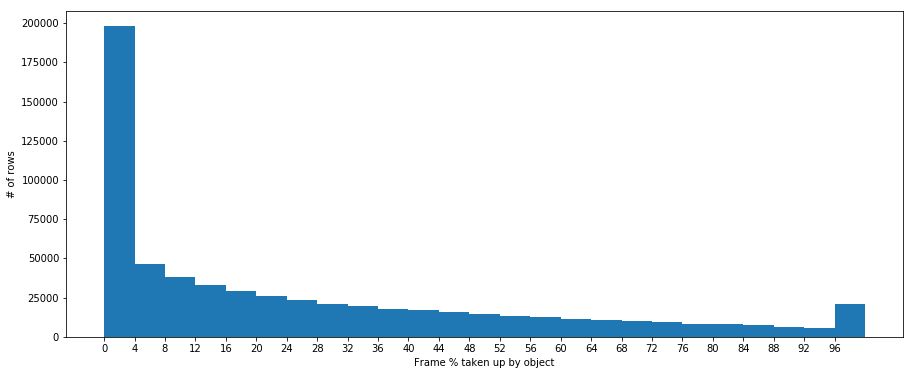

In [77]:
plt.hist(bb_sizes, bins=25)
plt.xticks(np.arange(0, 100.0, 100.0/25))
plt.xlabel("Frame % taken up by object")
plt.ylabel("# of rows")
plt.rcParams["figure.figsize"] = (15, 6)
plt.show()

In [94]:
classes = ["airplane", "bike", "bird", "boat", "bus",
           "car", "cat", "cow", "dog", "horse", "motorcycle",
           "person", "plotted plant", "train"]

# Each class has a set of 100 video segments
# Each segment is a list of rows with the same video-ID, class-ID, object-ID
vids = {clss: [] for clss in classes}
keep_absent = False
num_vids_per_class = 100

def possibly_add_segment(rows):
    # rows is a segment (see above)
    clss = rows[0][3]
    
    if clss not in classes:
        return
    
    if len(vids[clss]) < num_vids_per_class or random.random() < 0.5:
        vids[clss].append(rows)
        return
    
    # remove existing segment
    idx = random.randrange(0, len(vids[clss]))
    vids[clss][idx], vids[clss][-1] = vids[clss][-1], vids[clss][idx]
    vids[clss].pop()
    vids[clss].append(rows)

def process_vid_rows(rows):
    # sort to de-interleave rows since they're initially sorted by youtube-ID, timestamp
    # sort and group together by class-ID, object-ID, timestamp
    rows.sort(key=lambda row: (int(row[2]), int(row[4]), int(row[1])))

    curr = []
    for row in rows:
        if curr and row[2] == curr[0][2] and row[4] == curr[0][4]:
            possibly_add_segment(curr)
            del curr[:]
            
        curr.append(row)

with open("yt_bb_detection_validation.csv", "r") as f:
    reader = csv.reader(f)
    vid_rows = []
    for row in reader:
        if row[5] != 'present' and not keep_absent:
            continue
            
        if vid_rows and row[0] != vid_rows[0][0]:
            process_vid_rows(vid_rows)
            del vid_rows[:]
            
        vid_rows.append(row)

In [ ]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    segment_rows = []
    with open("yt_bb_detection_train.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if segment_rows and row[3] != segment_rows[0][3]:
                executor.submit(download_vid, list(segment_rows))
                del segment_rows[:]

            if row[3] in classes and (row[5] == 'present' or keep_absent):
                segment_rows.append(row)